## Airline Passenger Satisfaction
The dataset you'll be working with contains an airline passenger satisfaction survey. There are two primary questions of interest with this dataset:

**Questions of Interest:**
1. Can you predict passenger satisfaction?
2. What factors are associated with passenger satisfaction?

## 1. Data Prep & Preprocessing

In this section, I load in any packages necessary for the script to run an in-depth analysis on the Airline Passenger Satifaction data. After preparing the environment by loading the below packages, I begin to prepare and preprocess the data. I started by loading both datasets, then I concatenated the dataframes to one large dataframe with all the data. Next, I explored my options with cleaning the data. I reviewed how many missing values there were in the dataset. The combined dataset has the dimensions of 129,880 rows × 24 columns. Out of these 129,880 observations, I checked the presence of any NA values and found that there were 393 blank values in only the column of 'Arrival Delay in Minutes'. I experimented with filling these missing values with the column mean/median, but eventually decided to drop these rows as it was a very small percentage of the data. Lastly, I also created a new variable that combined 'Arrival Delay in Minutes' and 'Departure Delay in Minutes' into a single new column called 'Total Delay'. The final item I checked was the balance of the two classes, 'satified' and 'neutral or dissatisfied' to see if there was going to an imbalance that I would need to address in my modeling. I found that 'neutral or dissatisifed' had 73,225 observations, while 'satisfied' had 56,262 observations. While one class was still larger than the other, the dataset overall had a large number of observations for both groups and was not overly imbalanced in either direction. Considering the data provided was already very clean, balanced, and organized, my preprocessing process was streamlined, and from here I felt comfortable moving in the exploratory data analysis phase and modeling portion.

In [2]:
# Load in any necessary Libraries here:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import r2_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.simplefilter('ignore', FitFailedWarning)
warnings.simplefilter('ignore', UserWarning)


In [4]:
# Load in Datasets

data1 = pd.read_csv("/Users/ajtaghavi/Desktop/GSB-545-AdvML/PythonScripts/Midterm-Take-Home/data1.csv")
data2 = pd.read_csv("/Users/ajtaghavi/Desktop/GSB-545-AdvML/PythonScripts/Midterm-Take-Home/data2.csv")

# Drop unnamed index columns:
data1 = data1.drop(data1.columns[0], axis = 1)
data2 = data2.drop(data2.columns[0], axis = 1)

data1
data2

# Merge the two datasets
data = pd.concat([data1, data2], axis = 0, ignore_index = True)
data.head()


,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [8]:
# Additional Pre-processing

print(data.isnull().sum())

# 393 NAs in 'Arrival Delay in Minutes'
# Replace NA's with median values
# data['Arrival Delay in Minutes'].fillna(data['Arrival Delay in Minutes'].median(), inplace=True)
data = data.dropna()   
# Creating a new column for total delay
data['Total Delay'] = data['Departure Delay in Minutes'] + data['Arrival Delay in Minutes']


# See class distribution, counts for each class:
satisfaction_counts = data['satisfaction'].value_counts()
print(satisfaction_counts)


id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64
neu

/var/folders/w7/dyvg_q0d4_ndwclbxb8hfh3r0000gn/T/ipykernel_6924/2457583343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Total Delay'] = data['Departure Delay in Minutes'] + data['Arrival Delay in Minutes']


## 2. Exploratory Data Analysis (EDA)

In the second section of my analysis, I take time to review some summary statistics on the data, as well as review many summary visualizations to become more accustomed to the nature of the data and bolster my understanding within the relationships between certain explanatory variables. Further below, I will comment on my findings from certain statistics and visualizations, and share how they helped me shape my modeling/analysis.

In [84]:
print(data[['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Total Delay']].mean())


Age                             39.428761
Flight Distance               1190.210662
Departure Delay in Minutes      14.643385
Arrival Delay in Minutes        15.091129
Total Delay                     29.734514
dtype: float64


Above, I print out the mean values for the columns: Age, Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes, and Total Delay. This gave me an idea of where the data was distributed for these columns and I saw stats on the age of the passengers and the average distance travelled for the flights. Additionally I did a sanity check by the getting the mean values for the delay times to see if the column I created, matches up with the combined mean values of departure and arrival delay.

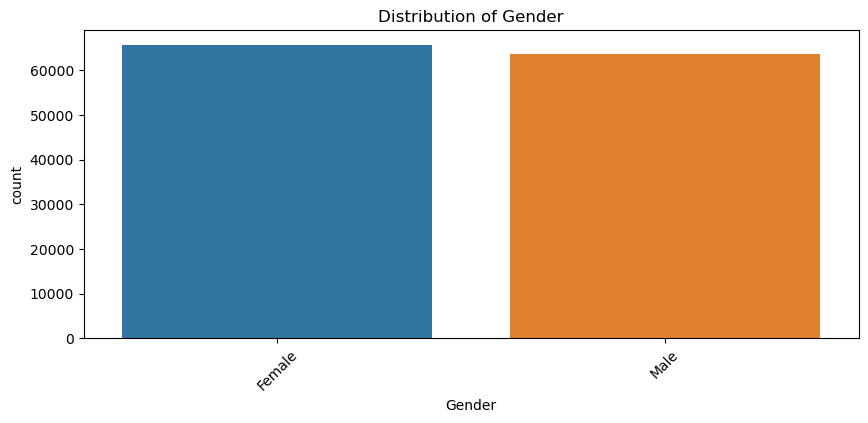

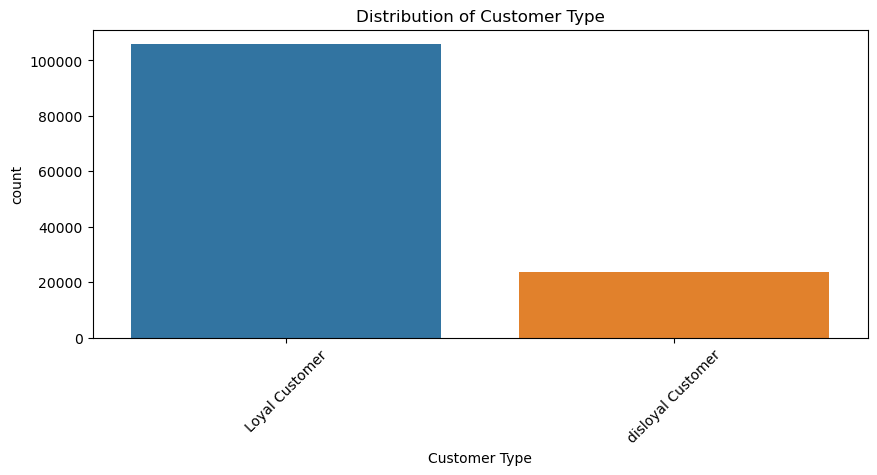

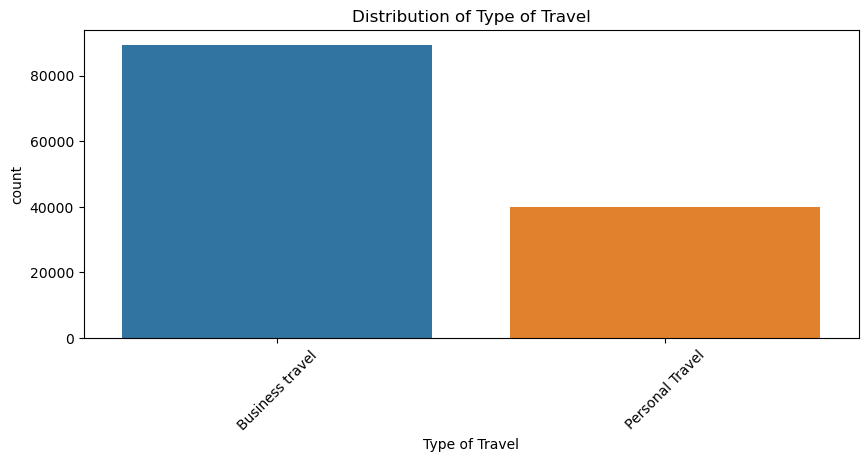

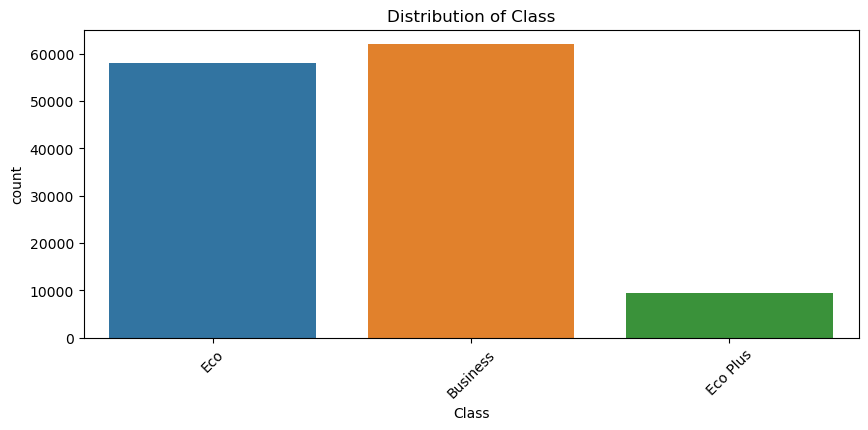

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_vars = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
for var in categorical_vars:
    plt.figure(figsize = (10, 4))
    sns.countplot(x = data[var])
    plt.title(f'Distribution of {var}')
    plt.xticks(rotation = 45)
    plt.show()


In the four visualizations above, I review the distribution for the different levels in the categorical variables: *Gender, Customer Type, Type of Travel, Class.*

**Gender Distribution:**
In the distrubution of gender, we see an almost equal split of female and male response, with females having slighly more observations - but not enough to highlight a concering disparity.

**Customer Type Distribution:**
For customer type, the classes were 'loyal customer' and 'disloyal customer'. This distribution did show a disparity, with there being almost five times the amount of observations from loyal customers than disloyal ones. This intuitively makes sense to me, as a loyal customer may have more experciences with the same airline and may be more willing to provide feedback based on those experiences. 

**Type of Travel Distribution:**
Type of Travel has the two values: Business Travel and Personal Travel, with Business Travel having more than double the amount of observation. This may be something to point out, as people with traveling for business purposes may have different preferences/expectations than those who travel for personal reasons. This may be useful to explore later in the analysis - for example business travelers may have higher expectations if there reservations are being paid by their employers vs. personal travelers putting more emphasis on the cost effectiveness of there trip. 

**Class Distribution:**
Lastly, I reviewed the counts of seating classes, with the options being: Eco, Business, and Eco Plus. As seen in the barplot above, we can see that the majority of observations are in class sections Eco and Business, with Business having a slightly larger amount of observations. Eco Plus had the smallest percentage of responses, with around 10,000 total observations. 


<Figure size 1200x1000 with 0 Axes>

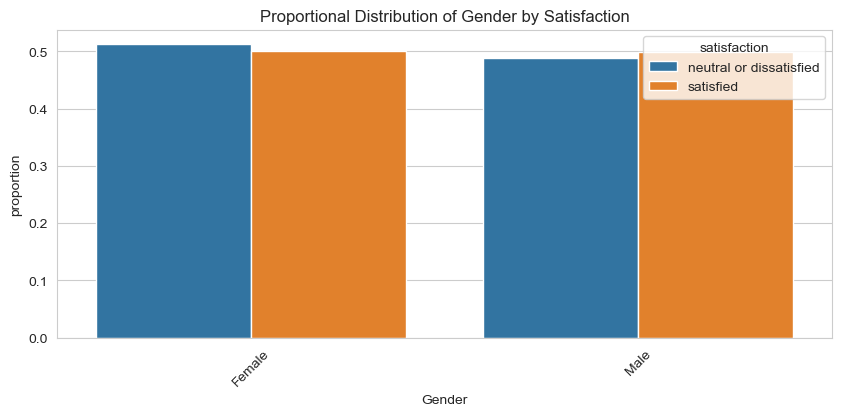

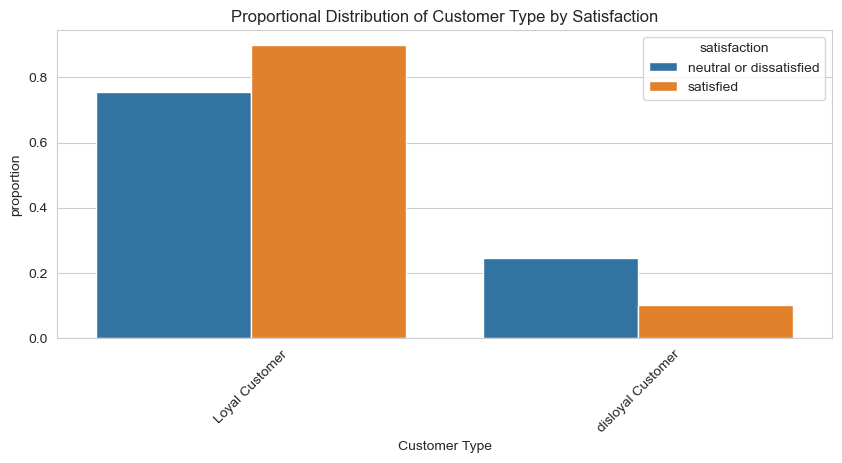

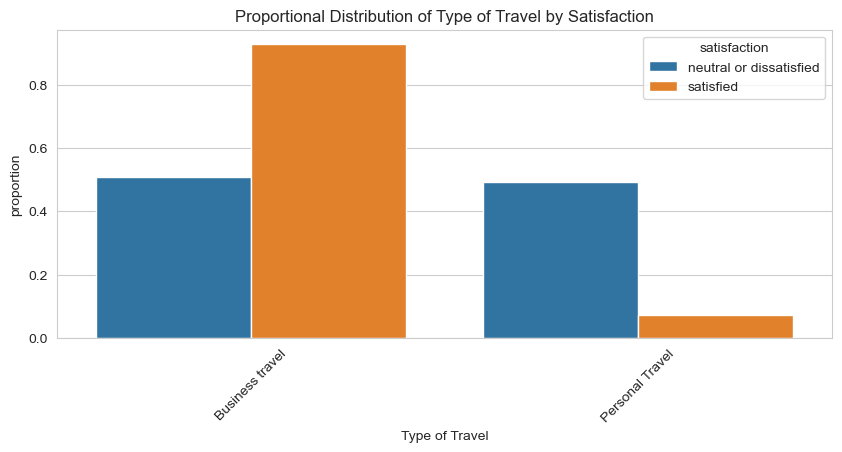

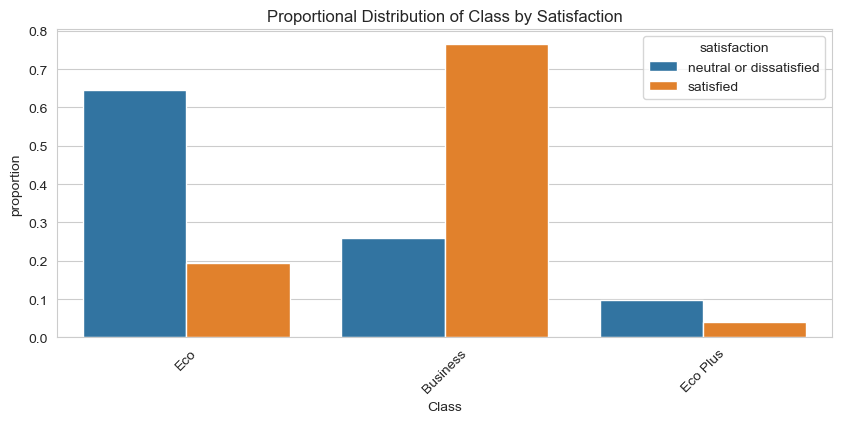

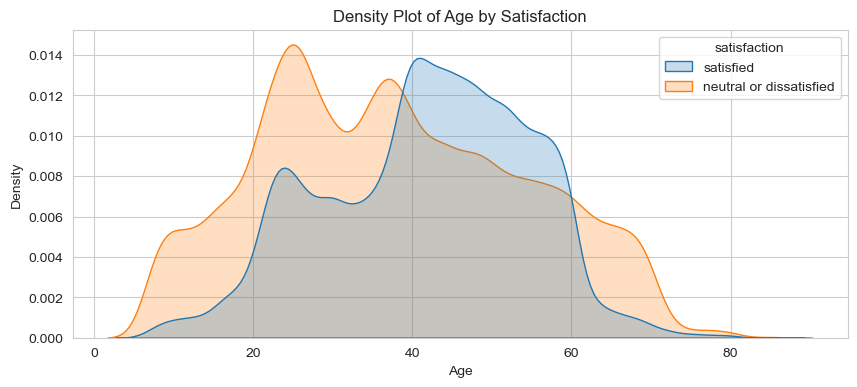

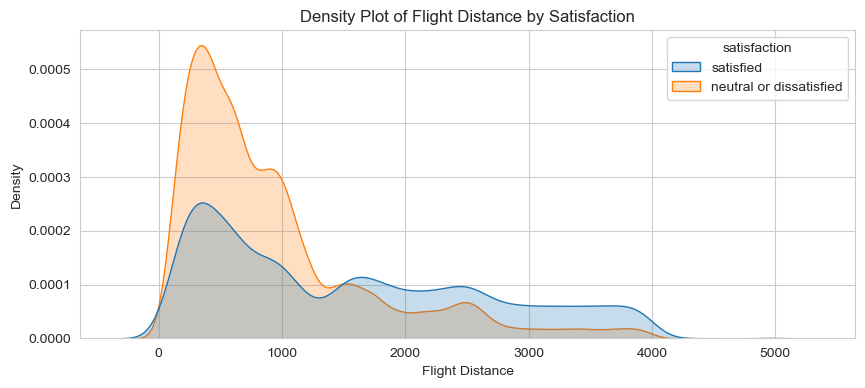

In [12]:
plt.figure(figsize = (12, 10))

# Proportionate Distribution of Categorical Variables
categorical_vars = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

for var in categorical_vars:
    plt.figure(figsize = (10, 4))
    category_proportions = (data.groupby(['satisfaction'])[var]
                                .value_counts(normalize = True)
                                .rename('proportion')
                                .reset_index())
    sns.barplot(x = var, y = 'proportion', hue = 'satisfaction', data = category_proportions)
    plt.title(f'Proportional Distribution of {var} by Satisfaction')
    plt.xticks(rotation = 45)
    plt.show()


# Distribution of Numerical Variables
numerical_vars = ['Age', 'Flight Distance']

for var in numerical_vars:
    plt.figure(figsize = (10, 4))
    sns.kdeplot(data = data, x = var, hue = 'satisfaction', fill = True)
    plt.title(f'Density Plot of {var} by Satisfaction')
    plt.show()
    

In the six visualizations above, we examine the proportion split on the variables gender, customer type, type of travel, class, age, and flight distance whike taking into account satisfaction responses.

**Gender:** 
We see an almost even split between satisfaction responses for both men and women.

**Customer Type:**
We see that there a larger amount of loyal customers than disloyal customers in the dataset, with there being a larger amount of satisfied loyal customers and a larger amount of dissatisfied disloyal customers.

**Type of Travel:**
We observe that over 90% of the satisfied responses come from passengers who are traveling for business, while for neutral/dissatisfied there is close to an equal split between types of travel. This can indicate that persons traveling for business are having much better travel experiences compared to others, and is a variable to explore further with its influence on satisfaction.

**Class:**
In Business Class, we see the highest proportion of satisfied customers - with about 75% of the satisfied responses being in business class. The largest proportion of neutral or dissatisfied came from the economy class, with this class taking into account almost 65% of the neutral or dissatisfied responses. This makes me curious on how class type effects satisfaction as there does seem be some differences between the groups.


**Age:**
Below, we see the distribution of age, however in this plot we it split between satisfied and disatisfied, and plotted by the density of the age values. The densities still seem to show a normal pattern, with the satisfied group have a slightly higher density at the older ages of 40-60, and neutral/dissatisfied have a higher density at the younger ages of 0-38 years old. 

**Flight Distance:**
As mentioned below, we see a higher density for both groups at shorter flights - however we see a higher density of dissatisfaction at shorter flight distances of 0-1,500 miles. After this threshold, we see a general trend of a drop in the density of dissatified passengers as the flight distance increases.

These visualizations provide more insight on what factors may be of interest to further explore through our modeling and what factors may be contributing to a passengers decision on satisfaction.

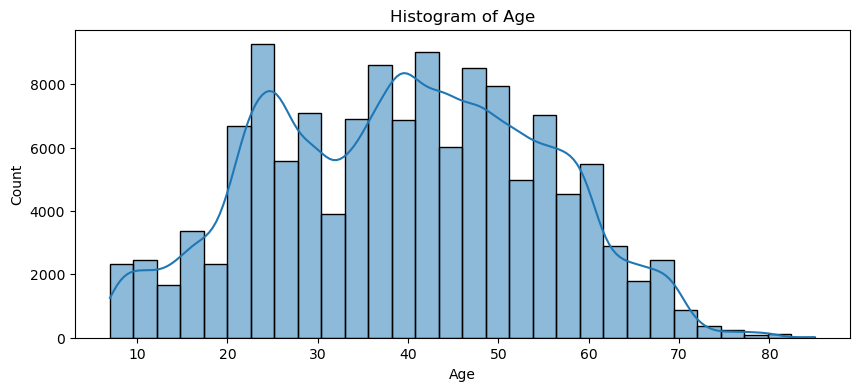

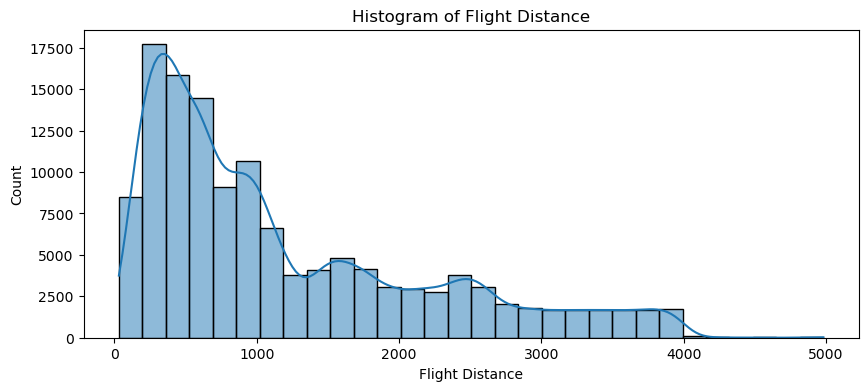

In [87]:
numerical_vars = ['Age', 'Flight Distance']

for var in numerical_vars:
    plt.figure(figsize = (10, 4))
    sns.histplot(data[var], kde = True, bins = 30)
    plt.title(f'Histogram of {var}')
    plt.show()


**Histrograms of Flight Distance and Age**

Above we see the observation distribution for both Age and Flight distance. This allows me to review if there were hidden anomalies that would not be seen by just looking at the mean/median values. The distribution of Age mostly follows a normal distribitution, which is what I expected to see, with it being centered around the 39/40.

The histogram of Flight Distance shows a right-skewed distribution, which is also what I expected to see, as shorter distance flights are more common and numerous because due to the time it takes to travel, the number of flights at shorter distances can be offered more often.

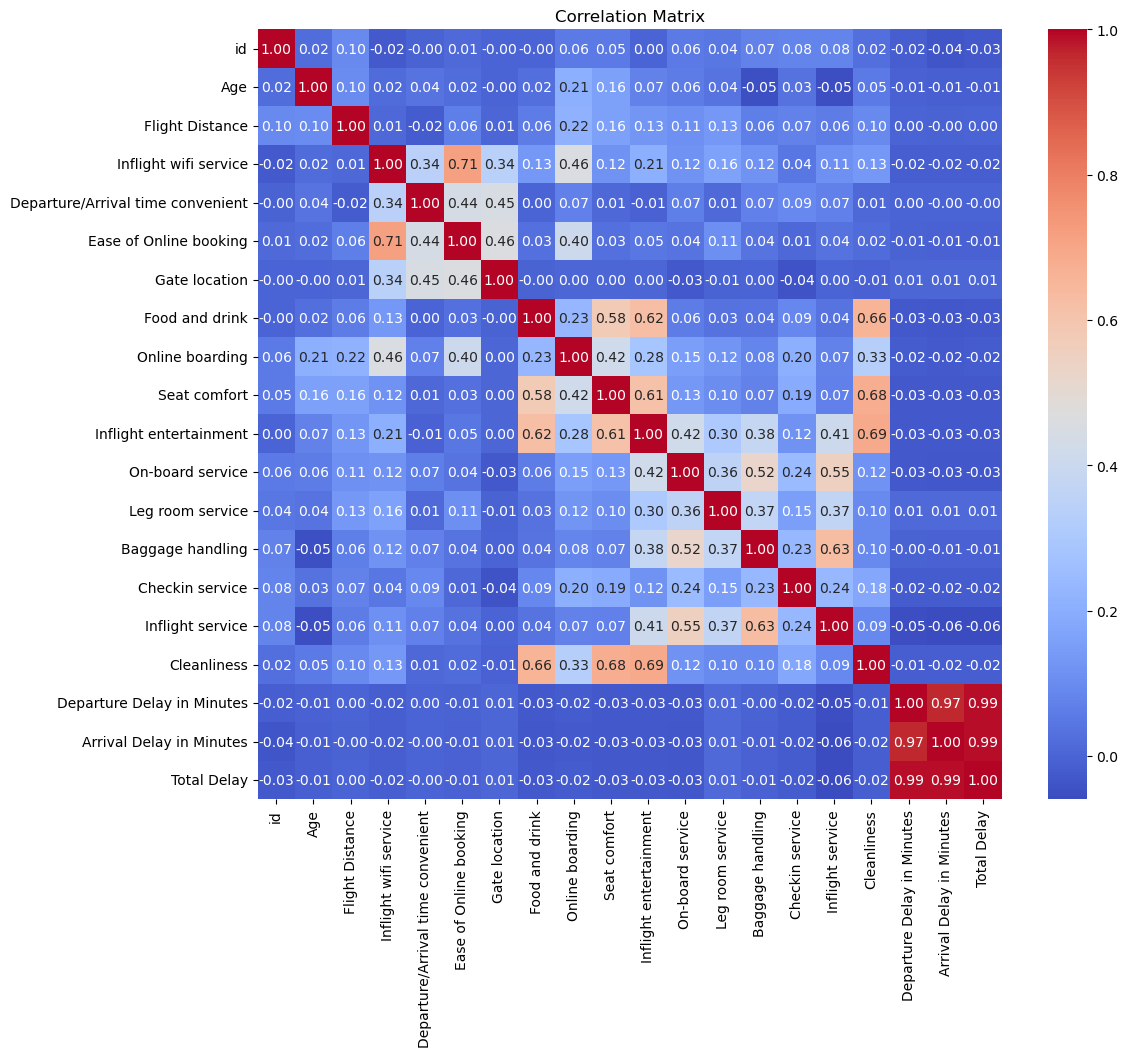

In [89]:
# Correlation Matrix

plt.figure(figsize = (12, 10))
sns.heatmap(data.select_dtypes(include = [np.number]).corr(), annot = True, fmt = ".2f", cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Correlation Matrix**

One of the last steps in my EDA was reviewing the correlation between the explanatory variables in the dataset. This would help me find any associations between the variables and see if there are any highly correlated relationships that would be a cause for concern before entering my modeling. Very clearly to begin with, we can see that Departure Delay in Minutes and Arrival Delay in Minutes and Total Delay are all positively and highly correlated with eachother (0.97+). This is obviously expected as Total Delay is derrived from the other two variables and a departure delay would result in adding to a potential arrival delay. Later in my model I experimented with variable selection between these three to see how it would effect the performance of my models. 

The next highest correlation was between Inflight Wifi Services and Ease of Online booking, with a positive correlation of 0.71. This can make sense on an initial view as if an airline has the technology and development quality to create a well designed website experience, this could be indicative of their technological level and ability to introduce wifi services on board (and vice versa). 

***It is an important reminder that the comments in this section are purely from an exploratory and observational view, and not definitive statements - they are solely assumptions being made to help create a deeper understanding of the variables and the relationships within them.*** 


## 3. Modeling

In [16]:
# Prepare Dataframes for Modeling

X = data.drop(['satisfaction', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], axis=1)
y = data['satisfaction']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)



In [14]:
# Creating Column Transformer for Data Pre-processing

ct = ColumnTransformer(
    [
        ('dummify', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), make_column_selector(dtype_include = object)),
        ('standardize', StandardScaler(), make_column_selector(dtype_include = np.number))
    ],
    remainder = "passthrough"
)

# CT that scales without negative values:
ct_cnb = ColumnTransformer(
    [
        ('dummify', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ('scale', MinMaxScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

### Naive Bayes

In [63]:
# Here I create the pipelines for the Naive Bayes classifier I will be testing the data on 


BNB_pipeline = Pipeline([
    ("pre-processing", ct),
    ("bernoulli_naive_bayes", BernoulliNB())
])



CNB_pipeline = Pipeline([
    ("pre-processing", ct_cnb),
    ("categorical_naive_bayes", CategoricalNB())
])



GNB_pipeline = Pipeline([
    ("pre-processing", ct),
    ("gaussian_naive_bayes", GaussianNB())
])


In [64]:
# I also create parameter grids for the Hyperparameter Tuning in the next step

params_bnb = {
    'bernoulli_naive_bayes__alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'bernoulli_naive_bayes__binarize': [0.0, 0.1, 0.2]
}

params_gnb = {
    'gaussian_naive_bayes__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

params_cnb = {
    'categorical_naive_bayes__alpha': [0.01, 0.1, 1.0, 10.0]
}

In [100]:
# I use hyperparameter tuning here to tune my models and run them via GridSearch cross validation. 
# At the end I print out the best scores for each classifier and each score to compare the results.

# For Bernoulli Naive Bayes

grid_bnb = GridSearchCV(BNB_pipeline, param_grid=params_bnb, cv=5, scoring='f1')
grid_bnb.fit(X, y_encoded)
BNB_f1 = grid_bnb.best_score_
print("Bernoulli Naive Bayes F1 Score: ", BNB_f1)

grid_bnb_acc = GridSearchCV(BNB_pipeline, param_grid=params_bnb, cv=5, scoring='accuracy')
grid_bnb_acc.fit(X, y_encoded)
BNB_acc = grid_bnb_acc.best_score_
print("Bernoulli Naive Bayes Accuracy: ", BNB_acc)

print("")


# For Gaussian Naive Bayes

grid_gnb = GridSearchCV(GNB_pipeline, param_grid=params_gnb, cv=5, scoring='f1')
grid_gnb.fit(X, y_encoded)
GNB_f1 = grid_gnb.best_score_
print("Gaussian Naive Bayes F1 Score: ", GNB_f1)

grid_gnb_acc = GridSearchCV(GNB_pipeline, param_grid=params_gnb, cv=5, scoring='accuracy')
grid_gnb_acc.fit(X, y_encoded)
GNB_acc = grid_gnb_acc.best_score_
print("Gaussian Naive Bayes Accuracy: ", GNB_acc)

print("")

# For Categorical Naive Bayes

grid_cnb = GridSearchCV(CNB_pipeline, param_grid=params_cnb, cv=5, scoring='f1')
grid_cnb.fit(X, y_encoded)
CNB_f1 = grid_cnb.best_score_
print("Categorical Naive Bayes F1 Score: ", CNB_f1)

grid_cnb_acc = GridSearchCV(CNB_pipeline, param_grid=params_cnb, cv=5, scoring='accuracy')
grid_cnb_acc.fit(X, y_encoded)
CNB_acc = grid_cnb_acc.best_score_
print("Categorical Naive Bayes Accuracy: ", CNB_acc)


Bernoulli Naive Bayes F1 Score:  0.840313284849092
Bernoulli Naive Bayes Accuracy:  0.8649054010226443

Gaussian Naive Bayes F1 Score:  0.8241639750924502
Gaussian Naive Bayes Accuracy:  0.8486180467574229

Categorical Naive Bayes F1 Score:  0.8024790953659326
Categorical Naive Bayes Accuracy:  0.820082351998464


### XGBoost

In [75]:
# Create XGBoost Pipeline

XGB_pipeline = Pipeline([
    ("pre-processing", ct),
    ("xgboost_classifier", xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

In [76]:
# Create Hyperparamer Value Grid

params_xgb = {
    'xgboost_classifier__n_estimators': [100, 150],  
    'xgboost_classifier__learning_rate': [0.05, 0.1], 
    'xgboost_classifier__max_depth': [3, 4],  
    'xgboost_classifier__subsample': [0.8],  
    'xgboost_classifier__colsample_bytree': [0.8] 
}


In [91]:
# Use GridSearchCV to test parameters and find our best metric scores

# For XGBoost F1 Score
grid_xgb_f1 = GridSearchCV(XGB_pipeline, param_grid=params_xgb, cv=5, scoring='f1')
grid_xgb_f1.fit(X, y_encoded)
xgb_f1 = grid_xgb_f1.best_score_
print("XGBoost F1 Score: ", xgb_f1)

# For XGBoost Accuracy
grid_xgb_acc = GridSearchCV(XGB_pipeline, param_grid=params_xgb, cv=5, scoring='accuracy')
grid_xgb_acc.fit(X, y_encoded)
xgb_acc = grid_xgb_acc.best_score_
print("XGBoost Accuracy: ", xgb_acc)


XGBoost F1 Score:  0.9503953609618867
XGBoost Accuracy:  0.9575555932439759


### Random Forest

In [8]:
# Create Random Forest Pipeline

RF_pipeline = Pipeline([
    ("pre-processing", ct),
    ("random_forest_classifier", RandomForestClassifier(random_state = 42))
])

In [9]:
# Create Random Forest parameter value grid

params_rf = {
    'random_forest_classifier__n_estimators': [100, 150], 
    'random_forest_classifier__max_depth': [10, 15],  
    'random_forest_classifier__min_samples_split': [5, 10], 
    'random_forest_classifier__min_samples_leaf': [2, 3],  
    'random_forest_classifier__max_features': ['sqrt'] 
}


In [10]:
# Use hyperparameter tuning here to tune the Random Forest model and run it via GridSearch cross-validation.
# At the end, I print out the best scores for each scoring metric to compare the results.

# For Random Forest F1 Score
grid_rf_f1 = GridSearchCV(RF_pipeline, param_grid=params_rf, cv=3, scoring='f1')
grid_rf_f1.fit(X, y_encoded)
rf_f1 = grid_rf_f1.best_score_
print("Random Forest F1 Score: ", rf_f1)

# For Random Forest Accuracy
grid_rf_acc = GridSearchCV(RF_pipeline, param_grid=params_rf, cv=3, scoring='accuracy')
grid_rf_acc.fit(X, y_encoded)
rf_acc = grid_rf_acc.best_score_
print("Random Forest Accuracy: ", rf_acc)



Random Forest F1 Score:  0.9563111892912491
Random Forest Accuracy:  0.9625654441918123


### Neural Networks

In [96]:
# Create a neural networks pipeline with MLPClassifier

NN_pipeline = Pipeline([
    ("pre-processing", ct),
    ("mlp_classifier", MLPClassifier(max_iter = 300, random_state = 42))
])


In [97]:
# Paramter Values Grid

params_nn = {
    'mlp_classifier__hidden_layer_sizes': [(50,), (100,)],
    'mlp_classifier__activation': ['relu', 'tanh'],
    'mlp_classifier__solver': ['adam'],
    'mlp_classifier__learning_rate_init': [0.001, 0.01]
}


In [99]:
# Use hyperparameter tuning here to tune the Neural Network model and run it via GridSearch cross-validation.
# At the end, I print out the best scores and parameters for each scoring metric to compare the results.

# Initial Testing for Best Parameters with GridSearchCV
grid_nn = GridSearchCV(NN_pipeline, param_grid=params_nn, cv=3, scoring='accuracy')
grid_nn.fit(X, y_encoded)
print("Neural Network Best Accuracy: ", grid_nn.best_score_)
print("Neural Network Best Parameters: ", grid_nn.best_params_)
print("")

# Apply best parameters from GridSearch to k-fold cross-validation for F1 and Accuracy Scores
# For Neural Network F1 Score
NN_f1 = cross_val_score(NN_pipeline.set_params(**grid_nn.best_params_), X, y_encoded, cv=3, scoring='f1').mean()
print("Neural Network F1 Score: ", NN_f1)

# For Neural Network Accuracy
NN_acc = cross_val_score(NN_pipeline.set_params(**grid_nn.best_params_), X, y_encoded, cv=3, scoring='accuracy').mean()
print("Neural Network Accuracy: ", NN_acc)


Neural Network Best Accuracy:  0.9609844914237636
Neural Network Best Parameters:  {'mlp_classifier__activation': 'relu', 'mlp_classifier__hidden_layer_sizes': (100,), 'mlp_classifier__learning_rate_init': 0.001, 'mlp_classifier__solver': 'adam'}

Neural Network F1 Score:  0.9544378616407122
Neural Network Accuracy:  0.9609844914237636


### Summary of Model Metrics Results

In [16]:

metric_scores = {
    "Model": ["Bernoulli Naive Bayes", "Gaussian Naive Bayes", "Categorical Naive Bayes", "XGBoost", "Random Forest", "Neural Network"],
    "F1 Score": [0.8403, 0.8242, 0.8025, 0.9504, 0.9563, 0.9544],
    "Accuracy": [0.8649, 0.8486, 0.8201, 0.9576, 0.9626, 0.9610]
}

score_df = pd.DataFrame(metric_scores)

# Sorted by F1 Score
sorted_by_f1 = score_df.sort_values(by = "F1 Score", ascending = False)

sorted_by_f1


,Model,F1 Score,Accuracy
4,Random Forest,0.9563,0.9626
5,Neural Network,0.9544,0.9610
3,XGBoost,0.9504,0.9576
0,Bernoulli Naive Bayes,0.8403,0.8649
1,Gaussian Naive Bayes,0.8242,0.8486
2,Categorical Naive Bayes,0.8025,0.8201


## 4. Interpretations

### Passenger Satisfaction Variables (Logistic Regression)

In [17]:
# Logistic Regression Pipeline
# Run Logistic regression to get variable coefficients for interpretability

lr_pipeline = ImbPipeline([
    ("preprocessing", ct),
    ("sampling", SMOTE()),
    ("logistic", LogisticRegression())
])

lr_pipeline.fit(X, y_encoded)


preprocessor = lr_pipeline.named_steps['preprocessing']
feature_names = preprocessor.get_feature_names_out()

coefficients = lr_pipeline.named_steps['logistic'].coef_[0]


feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by absolute values of coefficients in descending order
sorted_feature_coefficients = feature_coefficients.assign(Abs_Coefficient = feature_coefficients['Coefficient'].abs()).sort_values(by='Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)
print(sorted_feature_coefficients)

                                           Feature  Coefficient
5          dummify__Type of Travel_Personal Travel    -1.608546
3         dummify__Customer Type_disloyal Customer    -1.273789
4          dummify__Type of Travel_Business travel     1.062676
17                    standardize__Online boarding     0.806227
2            dummify__Customer Type_Loyal Customer     0.727918
12              standardize__Inflight wifi service     0.561153
8                          dummify__Class_Eco Plus    -0.528075
23                    standardize__Checkin service     0.416957
20                   standardize__On-board service     0.383126
7                               dummify__Class_Eco    -0.383111
6                          dummify__Class_Business     0.365316
21                   standardize__Leg room service     0.324042
0                           dummify__Gender_Female    -0.303257
25                        standardize__Cleanliness     0.294626
14             standardize__Ease of Onli

## 5. Conclusions

### Predicting Satisfaction

I ran 4 different model types (with 7 total model variations) using the passenger satisfaction data to create a machine learning model to best predict a passenger's satisfaction. For each of my models I explored different hyperparamter tuning options and used grid search cross validation to find the best performing settings. For the scoring metrics of my models I used both F1 and Accuracy through k-fold cross validation. Considering that the dataset was decently balanced, I decided to base my final model recommendations and comparisons on the accuracy score. 

**Naive Bayes**

The first model I ran was Naive Bayes, which I ran three variations for. I tested Bernoulli, Gaussian, and Categorical Naive Bayes classifiers. My hypothesis before running my models was that Bernoulli would perform the best for this dataset. I found through my research that Bernoulli NB was well suited for a target variable with 2 classes. This ended up being the case, as the Bernoulli Naive Bayes model finished with both the highest F1 and Accuracy scores than the other 2 NB models, with an accuracy of 86.49%.


**XGBoost**

Following testing Naive Bayes, I then attempted predicting satisfaction using XGBoost. I kept the variable selection the same between all of my model types for equal performance comparison. I saw a large improvement using XGBoost, with an accuracy score 95.76%.


**Random Forest**

Next I used Random Forest to see if I could further improve on my already high accuracy score from XGBoost. I followed similar steps by creating a hyperparameter value grid and using grid search to choose the best parameter values. Random Forest was the model that took the longest to run, but eventually completed running and reporting the highest scores out of all my models. I recieved an F1 score of 95.63% and an Accuracy score of 96.26%.

**Neural Networks**

To conclude, I tested a neural networks model to see which of my 4 model types would be the best performing. Similarly to my Random Forest model, this model took a long time to run. However, once it completed, I recieved a very high accuracy score of 96.10%. Both Neural Networks and XGBoost recieved relatively high performing scores, yet niether of them out-performed my Random Forest's model results.

**Final Results**

Overall, I was very suprised with my models' scoring metrics and found high levels prediction accuracy. As stated above, my best performing model was **Random Forest** with Neural Networks coming as a close second. Commenting on my model's ability to predict passenger satisfaction based on the variables included in this dataset, I am highly confident in the probability of my results being correct. 


### Factors Associated with Passenger Satisfaction

**Key Factors Influencing Passenger Satisfaction:**

***Customer Type:***
Loyal customers tend to be more satisfied compared to disloyal customers. This could be due to a familiarity with the service, more realistic expectations, or better treatment as repeat customers.

***Type of Travel:***
Business travelers are significantly more likely to be satisfied compared to those traveling for personal reasons. This may be due to the different expectations and experiences associated with business vs. personal travel.

***Travel Class:***
Passengers in Business class exhibit a higher satisfaction rate compared to those in Eco or Eco Plus. This is likely due to the enhanced comfort, service, and amenities provided in Business class.

***Inflight Services:***
High satisfaction with inflight services such as wifi, online boarding, and entertainment correlates positively with overall satisfaction. These amenities significantly enhance the passenger experience, especially on longer flights.

***Age:***
Older passengers tend to be more satisfied than younger ones. This could be linked to different expectations or priorities between age groups, with older passengers possibly valuing comfort and service more than younger passengers.

***Flight Distance:***
Longer flights tend to have a higher satisfaction rating, potentially because these flights are more likely to be equipped with better amenities and services. Moreover, passengers might be more forgiving as they prepare mentally for a longer journey.

### Insights from Logistic Regression:

The coefficients from the logistic regression model offer a quantitative insight into how much each factor influences the likelihood of a passenger being satisfied:

***Negative Coefficients (Decrease Satisfaction):*** 
Personal travel, disloyal customers, Eco class, higher total delay, and younger ages are associated with a decrease in satisfaction.

***Positive Coefficients (Increase Satisfaction):***
Factors like Business class travel, Business travel, on-board service, online boarding, and inflight wifi service are associated with increased satisfaction.


**Recommendations for Airline Strategy:**

***Enhance Customer Loyalty Programs:*** Given the strong positive impact of being a loyal customer on satisfaction, enhancing loyalty programs could be beneficial.

***Focus on Business Travelers:*** Customized services for business travelers can be expanded, considering their high satisfaction rates.

***Upgrade Inflight Services:*** Investing in better inflight services can lead to higher satisfaction, especially online boarding and wifi services.

***Improve Service in Economy Class:*** Considering the lower satisfaction in Eco class, improving service and comfort in this class could potentially uplift overall passenger satisfaction.



### Comments on the Data

This dataset is likely collected from customer satisfaction surveys that are administered post-flight, which can capture different aspects of the passenger experience. However, inherent biases such as self-selection might skew the data: typically, passengers with extremely positive or negative experiences may be more inclined to participate in such surveys, potentially overlooking the silent majority with moderate views.

To enhance the reliability and applicability of future surveys, it would be beneficial to ensure that a randomized sampling method is implemented, ensuring a representative demographic and experiential cross-section of all passengers for the results to be generalized to. Additionally, including follow-up questions that examine the reasons behind certain ratings could offer deeper insights and more actionable data for Airlines.


